In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'lines.markersize': 10})

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import ttest_1samp
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.stats import iqr

from copy import deepcopy

import divebomb

import time
import pickle

import importlib

np.random.seed(0)

import Preprocessor
import Parameters
import HHMM
import Visualisor

# Load in the HMMs

In [2]:
#model = 'hhmm_FV'
#titl = 'CarHHMM-DFT'

#model = 'hhmm_FV_uncorr'
#titl = 'HHMM-DFT'

#model = 'hhmm_V'
#titl = 'CarHHMM'

model = 'hmm_FV'
titl = 'CarHMM-DFT'


rngs = {'hhmm_FV': range(1501,2001),
        'hhmm_FV_uncorr': range(501,1001),
        'hhmm_V': range(1001,1501),
        'hmm_FV': range(1,501)}

#date = '07_22_20'
#date = '08_20_20'
#date = '09_08_20'
#date = 'new_sim'
#date = '07-06-2021'
date = '14-06-2021'

hhmms = []
for dataset_num in rngs[model]:
    try:
        file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
        with open(file, 'rb') as f:
            hhmm = pickle.load(f)
            hhmm.reorder_params()
            A = hhmm.SEs
            if A is None:
                print(file)
        hhmms.append(hhmm)
    except:
        print('../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num))

../../Params/sims/14-06-2021/hmm_FV_0_229


# Record True Parameters

In [3]:
### initialize parameters ####
ndives = 100
ndatasets = 1

# number of states for each substate
K0 = 2
K1 = 3

# dive duration parameters
dd_mu = np.array([27.27,127.07])
dd_sig = np.array([10.91,64.06])

dd_shape = np.square(dd_mu)/np.square(dd_sig)
dd_scale = np.square(dd_sig)/np.array(dd_mu)

# FoVeDBA parameters (this is for the SQUARE of the FoVeDBA)

# make shape decay like 1/n
FoVeDBA_sin_shape = np.array([[(1.0/n**3) for n in range(1,52)] for _ in range(K1)])
for i in range(K1):
    FoVeDBA_sin_shape[i,:] = FoVeDBA_sin_shape[i,:]/sum(FoVeDBA_sin_shape[i,1:11])

# scale needs to be constant
FoVeDBA_sin_scale = np.ones((K1,51))

# set mean and variance
FoVeDBA_mu = np.array([[34.98],[505.79],[9769.98]])
FoVeDBA_sig = np.array([[23.85],[516.68],[14462.55]])

# adjust shape and scale accordingly
FoVeDBA_sin_shape *= np.square(FoVeDBA_mu)/np.square(FoVeDBA_sig)
FoVeDBA_sin_scale *= np.square(FoVeDBA_sig)/FoVeDBA_mu

# average acceleration parameters
acc_mu = np.array([0.0,0.1,0.2])
acc_sig = np.array([0.05,0.1,0.3])

# intialize correlation within states
corr_crude = [0.0,0.0,0.0]
corr_fine = [0.97,0.83,0.61]

# randomly initialize a probablity transition matrix

eta_crude = np.array([[ 0.    , -1.6984],
                      [ 2.3471,  0.    ]])

ptm_crude = HHMM.eta_2_ptm(eta_crude)
print(ptm_crude)

eta_fine =  [np.array([[  0.    ,  -1.0873, -10.00 ],
                       [ -2.3615,   0.    , -2.823 ],
                       [ -10.000,  -1.1937,  0.    ]]),
              np.array([[  0.    ,  -2.0691,  -10.000],
                        [ -1.6902,   0.    ,  -3.1311],
                        [ -10.000,  -1.2303,   0.    ]])]

ptm_fine = [HHMM.eta_2_ptm(eta_fine[0]),
            HHMM.eta_2_ptm(eta_fine[1])]

print(ptm_fine)

[[0.84532565 0.15467435]
 [0.91270344 0.08729656]]
[array([[7.47847561e-01, 2.52118487e-01, 3.39522267e-05],
       [8.17181253e-02, 8.66771882e-01, 5.15099931e-02],
       [3.48387901e-05, 2.32589743e-01, 7.67375418e-01]]), array([[8.87827600e-01, 1.12132093e-01, 4.03073107e-05],
       [1.50211513e-01, 8.14231226e-01, 3.55572611e-02],
       [3.51324582e-05, 2.26120979e-01, 7.73843889e-01]])]


# Plot Empirical distribtuion
 - Compare with Fischer SEs

In [4]:
def make_2d_kde_theta(feature,theta0,hhmms,dive_type,N,include_corr=False,feature_name=''):
    
    # get mu and sigma and corr
    if dive_type == -1:
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[0][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    else:
        mus = np.array([hhmm.theta[1][dive_type][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][dive_type][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[1][dive_type][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    # get a 2-D histogram of these guys
    for i in range(N):

        xlim = [np.nanmean(mus[:,i])-3*np.nanstd(mus[:,i]),np.nanmean(mus[:,i])+3*np.nanstd(mus[:,i])]
        ylim = [np.nanmean(sigs[:,i])-3*np.nanstd(sigs[:,i]),np.nanmean(sigs[:,i])+3*np.nanstd(sigs[:,i])]
        zlim = [np.nanmean(corrs[:,i])-3*np.nanstd(corrs[:,i]),np.nanmean(corrs[:,i])+3*np.nanstd(corrs[:,i])]
        
        if theta0:
            xlim[0] = min(xlim[0],theta0['mu'][i])
            xlim[1] = max(xlim[1],theta0['mu'][i])
            ylim[0] = min(ylim[0],theta0['sig'][i])
            ylim[1] = max(ylim[1],theta0['sig'][i])
            zlim[0] = min(zlim[0],theta0['corr'][i])
            zlim[1] = max(zlim[1],theta0['corr'][i])
        
        if include_corr:
            fig, axs = plt.subplots(2,2,figsize = (6,6))

            plt.subplot(2,2,1)
            kernel = gaussian_kde([mus[:,i],corrs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,zlim[0]:zlim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + zlim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['corr'][i],'r*')
            plt.plot(np.nanmean(mus[:,i]),np.nanmean(corrs[:,i]),'w*')
            c = plt.colorbar()
            c.set_label('Density')
            plt.xticks([])
            if dive_type == -1:
                plt.ylabel(r'$\hat \phi_%s^{(%d)}$' % (feature_name,i+1))
            else:
                plt.ylabel(r'$\hat \phi_%s^{*(\cdot,%d)}$' % (feature_name,i+1))

            fig.delaxes(axs[0,1])

            plt.subplot(2,2,3)
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            plt.plot(np.nanmean(mus[:,i]),np.nanmean(sigs[:,i]),'w*')
            c = plt.colorbar()
            if dive_type == -1:
                plt.ylabel(r'$\hat \mu^{(%d)}$' % (i+1))
                plt.ylabel(r'$\hat \sigma^{(%d)}$' % (i+1))
            else:
                plt.xlabel(r'$\hat \mu_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
                plt.ylabel(r'$\hat \sigma_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
            
            plt.subplot(2,2,4)
            kernel = gaussian_kde([corrs[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[zlim[0]:zlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = zlim + ylim, aspect='auto')
            plt.plot(theta0['corr'][i],theta0['sig'][i],'r*')
            plt.plot(np.nanmean(corrs[:,i]),np.nanmean(sigs[:,i]),'w*')
            c = plt.colorbar()
            c.set_label('Density')
            if dive_type == -1:
                plt.xlabel(r'$\hat \phi_%s^{(%d)}$' % (feature_name,i+1))
            else:
                plt.xlabel(r'$\hat \phi_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
            plt.yticks([])
            fig.suptitle(titl)
            

            
        else:
            
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.figure(figsize = (4,3))
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            if theta0:
                plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            plt.plot(np.nanmean(mus[:,i]),np.nanmean(sigs[:,i]),'w*')
            c = plt.colorbar()
            c.set_label('Density')
            plt.xlabel(r'$\hat \mu$')
            plt.ylabel(r'$\hat \sigma$')
            plt.title(titl)
            if dive_type == -1:
                plt.xlabel(r'$\hat \mu^{(%d)}$' % (i+1))
                plt.ylabel(r'$\hat \sigma^{(%d)}$' % (i+1))
            else:
                plt.xlabel(r'$\hat \mu_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
                plt.ylabel(r'$\hat \sigma_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('../Plots/%s_MLE_density_%s_%d_%d.png'%(model,feature,dive_type,i),dpi=300)
        plt.show()
        
    print(r'$\hat \mu$ sample mean:', np.nanmean(mus,0))
    if theta0:
        print('Bias:', np.nanmean(mus,0) - np.array(theta0['mu']))
    print('Empirical Standard Error:', np.nanstd(mus,0))
    print('Fischer Standard Error:',np.nanmedian(mus_SE,0))
    print('pm:',np.nanstd(mus_SE,0))
    print('')

    print(r'$\sigma$ sample mean:', np.nanmean(sigs,0))
    if theta0:
        print('Bias:', np.nanmean(sigs,0) - np.array(theta0['sig']))
    print('Empirical Standard Error:', np.nanstd(sigs,0))
    print('Fischer Standard Error:',np.nanmedian(sigs_SE,0))
    print('pm:',np.nanstd(sigs_SE,0))
    print('')

    if include_corr:
        print(r'$\rho$ sample mean:', np.nanmean(corrs,0))
        if theta0:
            print('Bias:', np.nanmean(corrs,0) - np.array(theta0['corr']))
        print('Empirical Standard Error:', np.nanstd(corrs,0))
        print('Fischer Standard Error:',np.nanmedian(corrs_SE,0))
        print('pm:',np.nanstd(corrs_SE,0))
        print('')
        
    return


def make_2d_kde_gamma(G0,hhmms,dive_type,rownum):
    
    Gs = []
    SEs = []
    for hhmm in hhmms:
        if dive_type == -1:
            ptm = HHMM.eta_2_ptm(hhmm.eta[0])
            try:
                SE = hhmm.SEs['Gamma_coarse']
            except:
                print(hhmm.SEs)
            Gs.append(np.array([ptm[0,1],ptm[1,0]]))
            SEs.append(np.array([SE[0,1],SE[1,0]]))
        else:
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][dive_type])
            SE = hhmm.SEs['Gamma_fine'][dive_type]
            colnums = [0,1,2]
            colnums.remove(rownum)
            Gs.append(np.array([ptm[rownum,colnums[0]],
                                ptm[rownum,colnums[1]]]))
            SEs.append(np.array([SE[rownum,colnums[0]],
                                 SE[rownum,colnums[1]]]))

    Gs = np.array(Gs)
    
    xlim = [np.nanmean(Gs[:,0])-3*np.nanstd(Gs[:,0]),np.nanmean(Gs[:,0])+3*np.nanstd(Gs[:,0])]
    ylim = [np.nanmean(Gs[:,1])-3*np.nanstd(Gs[:,1]),np.nanmean(Gs[:,1])+3*np.nanstd(Gs[:,1])]
    
    if G0:
        xlim[0] = max(min(xlim[0],G0[0]),0.0)
        xlim[1] = min(max(xlim[1],G0[0]),1.0)
        ylim[0] = max(min(ylim[0],G0[1]),0.0)
        ylim[1] = min(max(ylim[1],G0[1]),1.0)
    
    Gs = Gs[~np.isnan(Gs).any(axis=1), :]
    kernel = gaussian_kde([Gs[:,0],Gs[:,1]])
    Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
    positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
    Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
    plt.figure(figsize=(4,3))
    plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
    if G0:
        plt.plot(G0[0],G0[1],'r*')
        plt.plot(np.nanmean(Gs[:,0]),np.nanmean(Gs[:,1]),'w*')
    c = plt.colorbar()
    c.set_label('Density')
    plt.xlabel('$\Gamma_{12}$')
    plt.ylabel('$\Gamma_{21}$')
    if dive_type == -1:
        plt.title(titl)
        plt.xlabel('$\hat \Gamma_{12}$')
        plt.ylabel('$\hat \Gamma_{21}$')
    else:
        plt.title(titl)
        plt.xlabel('$\hat \Gamma^{*(%d)}_{%d,%d}$' % (dive_type+1,rownum+1,colnums[0]+1))
        plt.ylabel('$\hat \Gamma^{*(%d)}_{%d,%d}$' % (dive_type+1,rownum+1,colnums[1]+1))
        
    plt.tight_layout()
    plt.savefig('../Plots/%s_Gamma_density_%d_row_%d.png'%(model,dive_type,rownum),dpi=300)
    plt.show()

    print('Sample Mean:', np.nanmean(Gs,0))
    if G0:
        print('Bias:', np.nanmean(Gs,0) - G0)
    print('Empirical Standard Error: \n', np.nanstd(Gs,0))
    print('Fischer Standard Error: \n', np.nanmedian(SEs,0))
    print('pm:', np.nanstd(SEs,0))
    
    return

# Consider $\hat \Gamma$

In [5]:
for i in range(500):
    try:
        if hhmms[i].SEs is None:
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[0])):
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[1][0])):
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[1][1])):
            hhmms.pop(i)
    except IndexError:
        break

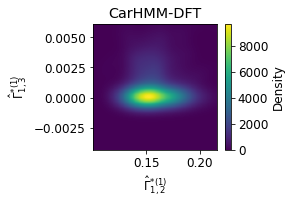

Sample Mean: [0.15791653 0.00088499]
Empirical Standard Error: 
 [0.01924025 0.0017453 ]
Fischer Standard Error: 
 [0.01414756        inf]
pm: [0.00188771        nan]


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning:

invalid value encountered in subtract



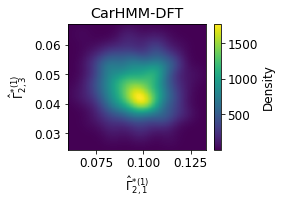

Sample Mean: [0.09649541 0.04575202]
Empirical Standard Error: 
 [0.0121517  0.00711009]
Fischer Standard Error: 
 [0.00995012 0.0066397 ]
pm: [0.00077163 0.00064985]


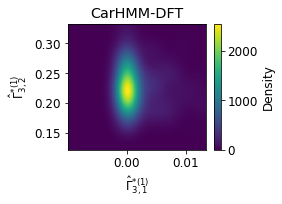

Sample Mean: [0.00167185 0.22700355]
Empirical Standard Error: 
 [0.00387641 0.03524672]
Fischer Standard Error: 
 [      inf 0.0300216]
pm: [       nan 0.00464666]


In [6]:
# make Gamma
G0_coarse = HHMM.eta_2_ptm(eta_crude)

G0_fine_1 = HHMM.eta_2_ptm(eta_fine[0])

G0_fine_2 = HHMM.eta_2_ptm(eta_fine[1])
if 'hhmm' in model:
    
    # Gamma Coarse
    make_2d_kde_gamma([G0_coarse[0,1],G0_coarse[1,0]],hhmms,-1,-1)
    
    # Gamma Fine 1
    make_2d_kde_gamma([G0_fine_1[0,1],G0_fine_1[0,2]],hhmms,0,0)
    make_2d_kde_gamma([G0_fine_1[1,0],G0_fine_1[1,2]],hhmms,0,1)
    make_2d_kde_gamma([G0_fine_1[2,0],G0_fine_1[2,1]],hhmms,0,2)
    
    # Gamma Fine 2
    make_2d_kde_gamma([G0_fine_2[0,1],G0_fine_2[0,2]],hhmms,1,0)
    make_2d_kde_gamma([G0_fine_2[1,0],G0_fine_2[1,2]],hhmms,1,1)
    make_2d_kde_gamma([G0_fine_2[2,0],G0_fine_2[2,1]],hhmms,1,2)
    
else:
    
    G0 = []
    make_2d_kde_gamma(G0,hhmms,0,0)
    make_2d_kde_gamma(G0,hhmms,0,1)
    make_2d_kde_gamma(G0,hhmms,0,2)

# Consider $\hat \Theta$ Coarse

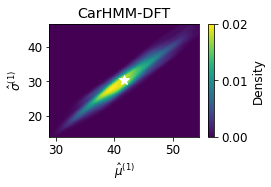

$\hat \mu$ sample mean: [41.684561]
Empirical Standard Error: [4.26793332]
Fischer Standard Error: [2.00074951]
pm: [0.26391802]

$\sigma$ sample mean: [30.29893585]
Empirical Standard Error: [5.43903486]
Fischer Standard Error: [1.94840682]
pm: [0.33474099]



In [7]:
# dive duration
if 'hhmm' in model:
    theta0 = {'mu':[27.27,127.07],'sig':[10.91,64.06],'corr':[0,0]}
    N = 2
else:
    sig = np.array([np.sqrt(np.nanmean(np.array([5,50])**2) + np.var(np.array([20,80])))])
    theta0 = None
    #theta0 = {'mu':[],'sig':[],'corr':[]}
    N = 1
    
make_2d_kde_theta('dive_duration',theta0,hhmms,-1,N,include_corr=False,feature_name='Y')

# Consider $\hat \theta^*$ Fine

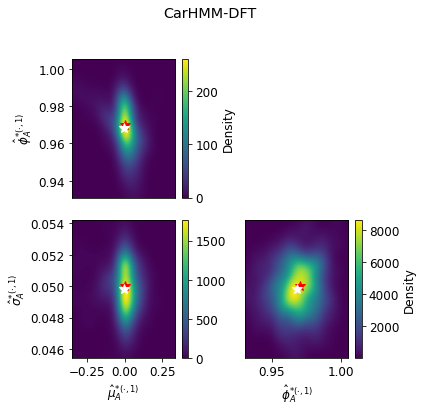

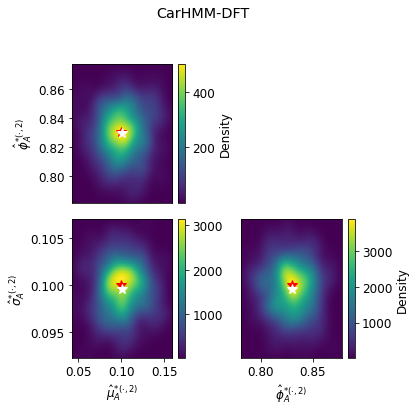

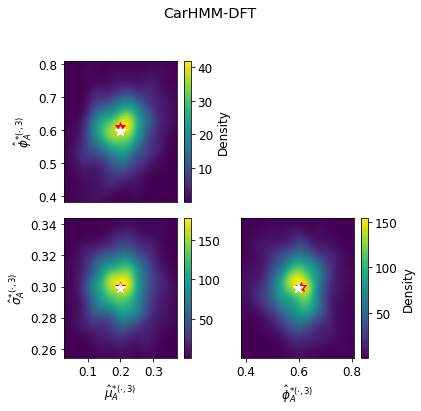

$\hat \mu$ sample mean: [-0.00751953  0.10067549  0.20023684]
Bias: [-0.00751953  0.00067549  0.00023684]
Empirical Standard Error: [0.11424104 0.01940992 0.05690326]
Fischer Standard Error: [0.06398459 0.01908557 0.05359445]
pm: [0.12159151 0.00212544 0.01139674]

$\sigma$ sample mean: [0.0498162  0.09959828 0.29894225]
Bias: [-0.0001838  -0.00040172 -0.00105775]
Empirical Standard Error: [0.00146846 0.00246004 0.01504509]
Fischer Standard Error: [0.00150003 0.00236567 0.01528485]
pm: [0.0001723  0.00013713 0.00166182]

$\rho$ sample mean: [0.96807882 0.82957146 0.59535505]
Bias: [-0.00192118 -0.00042854 -0.01464495]
Empirical Standard Error: [0.01238477 0.01605243 0.07105401]
Fischer Standard Error: [0.01037888 0.01650592 0.06504439]
pm: [0.00210727 0.00128019 0.0088428 ]



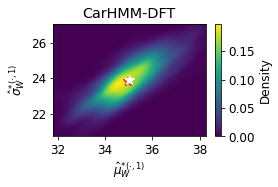

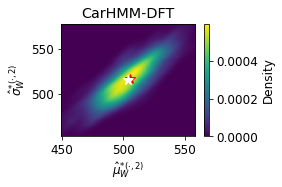

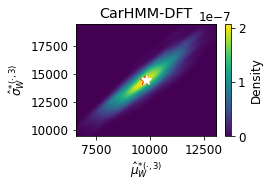

$\hat \mu$ sample mean: [  35.03390664  503.76168691 9817.78527551]
Bias: [ 0.05390664 -2.02831309 47.80527551]
Empirical Standard Error: [1.07626637e+00 1.82577586e+01 1.08910953e+03]
Fischer Standard Error: [  0.66056674   9.64067719 280.243724  ]
pm: [0.07071857 0.67310483        nan]

$\sigma$ sample mean: [   23.88981762   515.22764764 14437.86699891]
Bias: [  0.03981762  -1.45235236 -24.68300109]
Empirical Standard Error: [1.05787287e+00 2.10865477e+01 1.66076368e+03]
Fischer Standard Error: [  0.65585977  11.37072844 331.58884598]
pm: [0.07413906 0.77440267        nan]



In [8]:
# acceleration
N_star = 3
theta0 = {'mu':[0.0,0.1,0.2],'sig':[0.05,0.1,0.3],'corr':[0.97,0.83,0.61]}
dive_type = 0

if 'uncorr' in model:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='A')
else:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=True,feature_name='A')

if 'FV' in model:
    # FoVeDBA
    #F_mus0 = np.array([sum([5.0/n for n in range(2,12)]),
    #                   300 + sum([5.0/n for n in range(4,12)])])
    #F_sigs0 = np.sqrt(F_mus0)
    theta0 = {'mu':[34.98,505.79,9769.98],'sig':[23.85,516.68,14462.55],'corr':[0,0,0]}
    dive_type = 0
    make_2d_kde_theta('FoVeDBA',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='W')

# Get percentage of time in right dive and subdive states

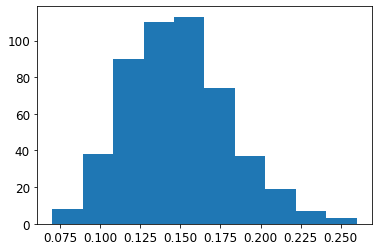

0.14721442885771543
0.033828165806441615


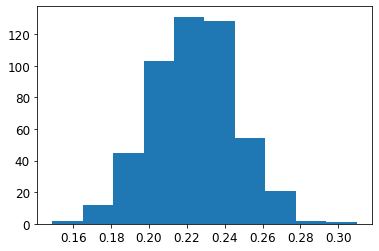

0.22392864798431278
0.022519002385072973


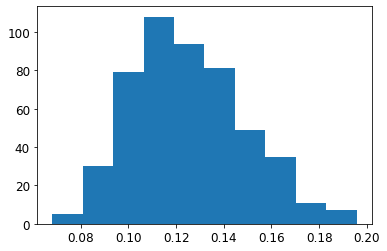

0.12538419066551953
0.023474287366481453


In [9]:
def acc(CM):
    return (CM[0,0]+CM[1,1])/np.sum(CM)

# get coarse accuracy
accuracies_coarse = [1.0-acc(hhmm.CM[0]) for hhmm in hhmms]
plt.hist(accuracies_coarse)
plt.show()
print(np.nanmean(accuracies_coarse))
print(np.nanstd(accuracies_coarse))

accuracies_fine0 = [1.0-acc(hhmm.CM[1][0]) for hhmm in hhmms]
plt.hist(accuracies_fine0)
plt.show()
print(np.nanmean(accuracies_fine0))
print(np.nanstd(accuracies_fine0))

accuracies_fine1 = [1.0-acc(hhmm.CM[1][1]) for hhmm in hhmms]
plt.hist(accuracies_fine1)
plt.show()
print(np.nanmean(accuracies_fine1))
print(np.nanstd(accuracies_fine1))

# Get time to train

In [10]:
hhmms[0].CM

[array([[82.,  0.],
        [18.,  0.]]),
 [array([[2.05822301e+02, 3.78412303e+01, 3.36468313e-01],
         [3.20476868e+01, 6.40052715e+02, 1.78995984e+01],
         [1.71499869e-01, 1.95994800e+01, 1.41229020e+02]]),
  array([[6.21763045e+02, 4.01611470e+01, 7.58078302e-02],
         [2.96341092e+01, 4.55981070e+02, 5.38482030e+00],
         [1.80437269e-01, 9.47006590e+00, 4.33494968e+01]])]]

44.81693425641987
21.556727819401292


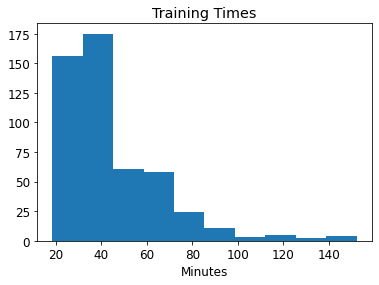

In [11]:
times = [hhmm.train_time/60.0 for hhmm in hhmms]
plt.hist(times)
plt.title('Training Times')
plt.xlabel('Minutes')
print(np.nanmean(times))
print(np.nanstd(times))

# Make Table for Report

In [12]:
def make_table_dd():
    
    feature = 'dive_duration'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    p_mus = []
    p_sigs = []
    
    for model in ['hhmm_FV','hhmm_FV_uncorr','hhmm_V','hmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    hhmm.reorder_params()
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        #if model == 'hhmm_FV':
        #    hhmms.pop(411) 
                
        # get estimates
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.nanmean(mus,0))
        try:
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])
        except:
            print(hhmms[1].SEs)
            print(feature)

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.nanmean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        # get biases a p-values
        if model == 'hmm_FV':
            bias_mus.append(np.array([np.nan]))
            bias_sigs.append(np.array([np.nan]))
            p_mus.append(np.array([np.nan]))
            p_sigs.append(np.array([np.nan]))
        else:
            bias_mus.append(est_mus[-1] - dd_mu)
            bias_sigs.append(est_sigs[-1] - dd_sig)
            p_mus.append(ttest_1samp(mus,dd_mu,axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,dd_sig,axis=0,nan_policy='omit')[1])
            
        # get empirical standard errors
        ESE_mus.append(np.nanstd(mus,0))
        ESE_sigs.append(np.nanstd(sigs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[]
\label{table:dive_duration}
\centering
\caption{Estimates and standard errors of parameters for dive duration distribution for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.9}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & ---                        & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & ---                        & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
        
    est_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    )
    return table

print(make_table_dd())

../../Params/sims/14-06-2021/hhmm_FV_0_1796
../../Params/sims/14-06-2021/hhmm_FV_0_1797
../../Params/sims/14-06-2021/hmm_FV_0_229

\begin{table}[]
\label{table:dive_duration}
\centering
\caption{Estimates and standard errors of parameters for dive duration distribution for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.9}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu$}        & 1                             & $27.337$                         & $0.067$ $(p=0.287)$          & $1.393$                             & $1.025 \pm 0.124$                             \\
                            &                   

In [13]:
def make_table_A():
    
    feature = 'A'
    
    est_mus = []
    est_sigs = []
    est_corrs = []
    bias_mus = []
    bias_sigs = []
    bias_corrs = []
    ESE_mus = []
    ESE_sigs = []
    ESE_corrs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    FSE_corrs = []
    FSE_corrs_SE = []
    p_mus = []
    p_sigs = []
    p_corrs = []
    
    for model in ['hhmm_FV','hhmm_FV_uncorr','hhmm_V','hmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    hhmm.reorder_params()
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                    
        #if model == 'hhmm_FV':
        #    hhmms.pop(411) 
            
        # get estimates
        mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.nanmean(mus,0))
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.nanmean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        corrs = expit(np.array([hhmm.theta[1][0][feature]['corr'] for hhmm in hhmms]))
        est_corrs.append(np.nanmean(corrs,0))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
        
        # get biases
        bias_mus.append(est_mus[-1] - acc_mu)
        p_mus.append(ttest_1samp(mus,acc_mu,axis=0,nan_policy='omit')[1])
        bias_sigs.append(est_sigs[-1] - acc_sig)
        p_sigs.append(ttest_1samp(sigs,acc_sig,axis=0,nan_policy='omit')[1])
        if model != 'hhmm_FV_uncorr':
            bias_corrs.append(est_corrs[-1] - np.array(corr_fine))
            p_corrs.append(ttest_1samp(corrs,corr_fine,axis=0,nan_policy='omit')[1])
        else:
            bias_corrs.append([])
            p_corrs.append([])

        # get empirical standard errors
        ESE_mus.append(np.nanstd(mus,0))
        ESE_sigs.append(np.nanstd(sigs,0))
        ESE_corrs.append(np.nanstd(corrs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
        FSE_corrs.append(np.nanmedian(corrs_SE,0))
        FSE_corrs_SE.append(iqr(corrs_SE,0,nan_policy='omit'))
        
    
    table = r'''
\begin{table}[]
\centering
\caption{Estimates and standard errors of parameters for $A^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{6}{*}{CarHHMM-DFT}& \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\multirow{6}{*}{HHMM-DFT}   & \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\ \hline
                            &                               & 3                                & ------                         & ------                     & ------                             & ------                                      \\
\multirow{6}{*}{CarHHMM}    & \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\multirow{6}{*}{CarHMM-DFT} & \multirow{3}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_mus[0][2],bias_mus[0][2],p_mus[0][2],ESE_mus[0][2],FSE_mus[0][2],FSE_mus_SE[0][2],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    est_sigs[0][2],bias_sigs[0][2],p_sigs[0][2],ESE_sigs[0][2],FSE_sigs[0][2],FSE_sigs_SE[0][2],
    est_corrs[0][0],bias_corrs[0][0],p_corrs[0][0],ESE_corrs[0][0],FSE_corrs[0][0],FSE_corrs_SE[0][0],
    est_corrs[0][1],bias_corrs[0][1],p_corrs[0][1],ESE_corrs[0][1],FSE_corrs[0][1],FSE_corrs_SE[0][1],
    est_corrs[0][2],bias_corrs[0][2],p_corrs[0][2],ESE_corrs[0][2],FSE_corrs[0][2],FSE_corrs_SE[0][2],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_mus[1][2],bias_mus[1][2],p_mus[1][2],ESE_mus[1][2],FSE_mus[1][2],FSE_mus_SE[1][2],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
    est_sigs[1][2],bias_sigs[1][2],p_sigs[1][2],ESE_sigs[1][2],FSE_sigs[1][2],FSE_sigs_SE[1][2],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_mus[2][2],bias_mus[2][2],p_mus[2][2],ESE_mus[2][2],FSE_mus[2][2],FSE_mus_SE[2][2],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
    est_sigs[2][2],bias_sigs[2][2],p_sigs[2][2],ESE_sigs[2][2],FSE_sigs[2][2],FSE_sigs_SE[2][2],    
    est_corrs[2][0],bias_corrs[2][0],p_corrs[2][0],ESE_corrs[2][0],FSE_corrs[2][0],FSE_corrs_SE[2][0],
    est_corrs[2][1],bias_corrs[2][1],p_corrs[2][1],ESE_corrs[2][1],FSE_corrs[2][1],FSE_corrs_SE[2][1],
    est_corrs[2][2],bias_corrs[2][2],p_corrs[2][2],ESE_corrs[2][2],FSE_corrs[2][2],FSE_corrs_SE[2][2],    
    
    est_mus[3][0],bias_mus[3][0],p_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],p_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_mus[3][2],bias_mus[3][2],p_mus[3][2],ESE_mus[3][2],FSE_mus[3][2],FSE_mus_SE[3][2],
    est_sigs[3][0],bias_sigs[3][0],p_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],p_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    est_sigs[3][2],bias_sigs[3][2],p_sigs[3][2],ESE_sigs[3][2],FSE_sigs[3][2],FSE_sigs_SE[3][2],
    est_corrs[3][0],bias_corrs[3][0],p_corrs[3][0],ESE_corrs[3][0],FSE_corrs[3][0],FSE_corrs_SE[3][0],
    est_corrs[3][1],bias_corrs[3][1],p_corrs[3][1],ESE_corrs[3][1],FSE_corrs[3][1],FSE_corrs_SE[3][1],
    est_corrs[3][2],bias_corrs[3][2],p_corrs[3][2],ESE_corrs[3][2],FSE_corrs[3][2],FSE_corrs_SE[3][2],
    )
    return table

print(make_table_A())

../../Params/sims/14-06-2021/hhmm_FV_0_1796
../../Params/sims/14-06-2021/hhmm_FV_0_1797


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning:

invalid value encountered in subtract



../../Params/sims/14-06-2021/hmm_FV_0_229

\begin{table}[]
\centering
\caption{Estimates and standard errors of parameters for $A^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{6}{*}{CarHHMM-DFT}& \multirow{3}{*}{$\mu_A^*$}    & 1                                & $-0.012$                         & $-0.012$ $(p=0.004)$          & $0.093$                             & $0.066 \pm 0.038$                             \\
                            &                               & 2                                & $0.099$                         & $-0.001$ $(p=0.436)$          & $0.019$

In [14]:
def make_table_FoVeDBA():
    
    F_mus0 = FoVeDBA_mu.flatten()
    F_sigs0 = FoVeDBA_sig.flatten()
    
    feature = 'FoVeDBA'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    p_mus = []
    p_sigs = []
    
    for model in ['hhmm_FV','hhmm_FV_uncorr','hhmm_V','hmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    hhmm.reorder_params()
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        #if model == 'hhmm_FV':
        #    hhmms.pop(411) 
            
        # get estimates
        if model != 'hhmm_V':
            mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
            est_mus.append(np.nanmean(mus,0))
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

            sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
            est_sigs.append(np.nanmean(sigs,0))
            sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

            # get biases
            bias_mus.append(est_mus[-1] - F_mus0)
            bias_sigs.append(est_sigs[-1] - F_sigs0)
            
            # get p-values
            p_mus.append(ttest_1samp(mus,F_mus0,axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,F_sigs0,axis=0,nan_policy='omit')[1])
            
            # get empirical standard errors
            ESE_mus.append(np.nanstd(mus,0))
            ESE_sigs.append(np.nanstd(sigs,0))

            # get Fischer Standard Errors
            FSE_mus.append(np.nanmedian(mus_SE,0))
            FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
            FSE_sigs.append(np.nanmedian(sigs_SE,0))
            FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of parameters for $W^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}       \\ \hline
\multirow{6}{*}{CarHHMM-DFT}& \multirow{3}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{6}{*}{HHMM-DFT}   & \multirow{3}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{6}{*}{CarHHMM}    & \multirow{3}{*}{$\mu_W^*$}    & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 3                                & ------                         & ------                     & ------                             & ------                                      \\
                            & \multirow{3}{*}{$\sigma_W^*$} & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 3                                & ------                         & ------                     & ------                             & ------                                      \\
\multirow{6}{*}{CarHMM-DFT} & \multirow{3}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{3}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 3                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_mus[0][2],bias_mus[0][2],p_mus[0][2],ESE_mus[0][2],FSE_mus[0][2],FSE_mus_SE[0][2],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    est_sigs[0][2],bias_sigs[0][2],p_sigs[0][2],ESE_sigs[0][2],FSE_sigs[0][2],FSE_sigs_SE[0][2],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_mus[1][2],bias_mus[1][2],p_mus[1][2],ESE_mus[1][2],FSE_mus[1][2],FSE_mus_SE[1][2],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
    est_sigs[1][2],bias_sigs[1][2],p_sigs[1][2],ESE_sigs[1][2],FSE_sigs[1][2],FSE_sigs_SE[1][2],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_mus[2][2],bias_mus[2][2],p_mus[2][2],ESE_mus[2][2],FSE_mus[2][2],FSE_mus_SE[2][2],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
    est_sigs[2][2],bias_sigs[2][2],p_sigs[2][2],ESE_sigs[2][2],FSE_sigs[2][2],FSE_sigs_SE[2][2],
    )
    return table
print(make_table_FoVeDBA())

../../Params/sims/14-06-2021/hhmm_FV_0_1796
../../Params/sims/14-06-2021/hhmm_FV_0_1797
../../Params/sims/14-06-2021/hmm_FV_0_229

\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of parameters for $W^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}       \\ \hline
\multirow{6}{*}{CarHHMM-DFT}& \multirow{3}{*}{$\mu_W^*$}    & 1                                & $34.981$                         & $0.001$ $(p=0.978)$          & $1.026$                             & $0.658 \pm 0.088$                             \\
                            &                               & 2

In [15]:
def make_table_Gamma():
    
    est_G0 = []
    est_G10 = []
    est_G11 = []
    bias_G0 = []
    bias_G10 = []
    bias_G11 = []
    ESE_G0 = []
    ESE_G10 = []
    ESE_G11 = []
    FSE_G0 = []
    FSE_G10 = []
    FSE_G11 = []
    FSE_G0_SE = []
    FSE_G10_SE = []
    FSE_G11_SE = []
    p0 = []
    p10 = []
    p11 = []
    
    for model in ['hhmm_FV','hhmm_FV_uncorr','hhmm_V','hmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    hhmm.reorder_params()
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        if model == 'hhmm_FV':
            hhmms.pop(411) 
                
        G0 = []
        SE0 = []
        G10 = []
        SE10 = []
        G11 = []
        SE11 = []
        
        for hhmm in hhmms:
            if model != 'hmm_FV':
                
                # coarse
                ptm = HHMM.eta_2_ptm(hhmm.eta[0])
                SE = hhmm.SEs['Gamma_coarse']
                G0.append(np.array([ptm[0,1],ptm[1,0]]))
                SE0.append(np.array([SE[0,1],SE[1,0]]))
                
                # fine
                ptm = HHMM.eta_2_ptm(hhmm.eta[1][1])
                SE = hhmm.SEs['Gamma_fine'][1]
                G11.append(np.array([[ptm[0,1],ptm[0,2]],
                                     [ptm[1,0],ptm[1,2]],
                                     [ptm[2,0],ptm[2,1]]]))
                SE11.append(np.array([[SE[0,1],SE[0,2]],
                                     [SE[1,0],SE[1,2]],
                                     [SE[2,0],SE[2,1]]]))
            
            # fine for both HMM and HHMM
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][0])
            SE = hhmm.SEs['Gamma_fine'][0]
            G10.append(np.array([[ptm[0,1],ptm[0,2]],
                                 [ptm[1,0],ptm[1,2]],
                                 [ptm[2,0],ptm[2,1]]]))
            SE10.append(np.array([[SE[0,1],SE[0,2]],
                                 [SE[1,0],SE[1,2]],
                                 [SE[2,0],SE[2,1]]]))

            if model == 'hmm_FV':
                G0.append([])
                SE0.append([])
                G11.append([])
                SE11.append([])
            
        # get estimates
        est_G0.append(np.nanmean(G0,0))
        est_G10.append(np.nanmean(G10,0))
        est_G11.append(np.nanmean(G11,0))
        
        
        # get biases
        if model != 'hmm_FV':
            bias_G0.append(est_G0[-1] - np.array([G0_coarse[0,1],G0_coarse[1,0]]))
            bias_G10.append(est_G10[-1] - np.array([[G0_fine_1[0,1],G0_fine_1[0,2]],
                                                    [G0_fine_1[1,0],G0_fine_1[1,2]],
                                                    [G0_fine_1[2,0],G0_fine_1[2,1]]]))
            bias_G11.append(est_G10[-1] - np.array([[G0_fine_2[0,1],G0_fine_2[0,2]],
                                                    [G0_fine_2[1,0],G0_fine_2[1,2]],
                                                    [G0_fine_2[2,0],G0_fine_2[2,1]]]))
            p0.append(ttest_1samp(G0,[G0_coarse[0,1],G0_coarse[1,0]],axis=0,nan_policy='omit')[1])
            p10.append(ttest_1samp(G10,np.array([[G0_fine_1[0,1],G0_fine_1[0,2]],
                                                 [G0_fine_1[1,0],G0_fine_1[1,2]],
                                                 [G0_fine_1[2,0],G0_fine_1[2,1]]]),axis=0,nan_policy='omit')[1])
            p11.append(ttest_1samp(G11,np.array([[G0_fine_2[0,1],G0_fine_2[0,2]],
                                                 [G0_fine_2[1,0],G0_fine_2[1,2]],
                                                 [G0_fine_2[2,0],G0_fine_2[2,1]]]),axis=0,nan_policy='omit')[1])
            
            #bias_G0.append(est_G0[-1] - np.array([0.5,0.5]))
            #bias_G10.append(est_G10[-1] - np.array([0.5,0.1]))
            #bias_G11.append(est_G11[-1] - np.array([0.2,0.3]))
            #p0.append(ttest_1samp(G0,[0.5,0.5],axis=0,nan_policy='omit')[1])
            #p10.append(ttest_1samp(G10,[0.5,0.1],axis=0,nan_policy='omit')[1])
            #p11.append(ttest_1samp(G11,[0.2,0.3],axis=0,nan_policy='omit')[1])
        else:
            bias_G0.append([])
            bias_G10.append([])
            bias_G11.append([])
            p0.append([])
            p10.append([])
            p11.append([])

        # get empirical standard errors
        ESE_G0.append(np.nanstd(G0,0))
        ESE_G10.append(np.nanstd(G10,0))
        ESE_G11.append(np.nanstd(G11,0))
        
        # get Fischer Standard Errors
        FSE_G0.append(np.nanmedian(SE0,0))
        FSE_G0_SE.append(iqr(SE0,0,nan_policy='omit'))
        FSE_G10.append(np.nanmedian(SE10,0))
        FSE_G10_SE.append(iqr(SE10,0,nan_policy='omit'))
        FSE_G11.append(np.nanmedian(SE11,0))
        FSE_G11_SE.append(iqr(SE11,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\Gamma$ and $\Gamma^*$ for all four models. All reported values are averages except for the observed fisher SE, which is a median. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                        & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{14}{*}{CarHHMM-DFT}& $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\multirow{14}{*}{HHMM-DFT}   & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\multirow{14}{*}{CarHHMM}    & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{13}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{23}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{31}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{32}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
\multirow{14}{*}{CarHMM-DFT} & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{13}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{23}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{31}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{32}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
\end{tabular}
}
\end{table}
    ''' % (
        
    est_G0[0][0],bias_G0[0][0],p0[0][0],ESE_G0[0][0],FSE_G0[0][0],FSE_G0_SE[0][0],
    est_G0[0][1],bias_G0[0][1],p0[0][1],ESE_G0[0][1],FSE_G0[0][1],FSE_G0_SE[0][1],
    est_G10[0][0,0],bias_G10[0][0,0],p10[0][0,0],ESE_G10[0][0,0],FSE_G10[0][0,0],FSE_G10_SE[0][0,0],
    est_G10[0][0,1],bias_G10[0][0,1],p10[0][0,1],ESE_G10[0][0,1],FSE_G10[0][0,1],FSE_G10_SE[0][0,1],
    est_G10[0][1,0],bias_G10[0][1,0],p10[0][1,0],ESE_G10[0][1,0],FSE_G10[0][1,0],FSE_G10_SE[0][1,0],
    est_G10[0][1,1],bias_G10[0][1,1],p10[0][1,1],ESE_G10[0][1,1],FSE_G10[0][1,1],FSE_G10_SE[0][1,1],
    est_G10[0][2,0],bias_G10[0][2,0],p10[0][2,0],ESE_G10[0][2,0],FSE_G10[0][2,0],FSE_G10_SE[0][2,0],
    est_G10[0][2,1],bias_G10[0][2,1],p10[0][2,1],ESE_G10[0][2,1],FSE_G10[0][2,1],FSE_G10_SE[0][2,1],
    est_G11[0][0,0],bias_G11[0][0,0],p11[0][0,0],ESE_G11[0][0,0],FSE_G11[0][0,0],FSE_G11_SE[0][0,0],
    est_G11[0][0,1],bias_G11[0][0,1],p11[0][0,1],ESE_G11[0][0,1],FSE_G11[0][0,1],FSE_G11_SE[0][0,1],
    est_G11[0][1,0],bias_G11[0][1,0],p11[0][1,0],ESE_G11[0][1,0],FSE_G11[0][1,0],FSE_G11_SE[0][1,0],
    est_G11[0][1,1],bias_G11[0][1,1],p11[0][1,1],ESE_G11[0][1,1],FSE_G11[0][1,1],FSE_G11_SE[0][1,1],
    est_G11[0][2,0],bias_G11[0][2,0],p11[0][2,0],ESE_G11[0][2,0],FSE_G11[0][2,0],FSE_G11_SE[0][2,0],
    est_G11[0][2,1],bias_G11[0][2,1],p11[0][2,1],ESE_G11[0][2,1],FSE_G11[0][2,1],FSE_G11_SE[0][2,1],

    est_G0[1][0],bias_G0[1][0],p0[1][0],ESE_G0[1][0],FSE_G0[1][0],FSE_G0_SE[1][0],
    est_G0[1][1],bias_G0[1][1],p0[1][1],ESE_G0[1][1],FSE_G0[1][1],FSE_G0_SE[1][1],
    est_G10[1][0,0],bias_G10[1][0,0],p10[1][0,0],ESE_G10[1][0,0],FSE_G10[1][0,0],FSE_G10_SE[1][0,0],
    est_G10[1][0,1],bias_G10[1][0,1],p10[1][0,1],ESE_G10[1][0,1],FSE_G10[1][0,1],FSE_G10_SE[1][0,1],
    est_G10[1][1,0],bias_G10[1][1,0],p10[1][1,0],ESE_G10[1][1,0],FSE_G10[1][1,0],FSE_G10_SE[1][1,0],
    est_G10[1][1,1],bias_G10[1][1,1],p10[1][1,1],ESE_G10[1][1,1],FSE_G10[1][1,1],FSE_G10_SE[1][1,1],
    est_G10[1][2,0],bias_G10[1][2,0],p10[1][2,0],ESE_G10[1][2,0],FSE_G10[1][2,0],FSE_G10_SE[1][2,0],
    est_G10[1][2,1],bias_G10[1][2,1],p10[1][2,1],ESE_G10[1][2,1],FSE_G10[1][2,1],FSE_G10_SE[1][2,1],
    est_G11[1][0,0],bias_G11[1][0,0],p11[1][0,0],ESE_G11[1][0,0],FSE_G11[1][0,0],FSE_G11_SE[1][0,0],
    est_G11[1][0,1],bias_G11[1][0,1],p11[1][0,1],ESE_G11[1][0,1],FSE_G11[1][0,1],FSE_G11_SE[1][0,1],
    est_G11[1][1,0],bias_G11[1][1,0],p11[1][1,0],ESE_G11[1][1,0],FSE_G11[1][1,0],FSE_G11_SE[1][1,0],
    est_G11[1][1,1],bias_G11[1][1,1],p11[1][1,1],ESE_G11[1][1,1],FSE_G11[1][1,1],FSE_G11_SE[1][1,1],
    est_G11[1][2,0],bias_G11[1][2,0],p11[1][2,0],ESE_G11[1][2,0],FSE_G11[1][2,0],FSE_G11_SE[1][2,0],
    est_G11[1][2,1],bias_G11[1][2,1],p11[1][2,1],ESE_G11[1][2,1],FSE_G11[1][2,1],FSE_G11_SE[1][2,1],
        
    est_G0[2][0],bias_G0[2][0],p0[2][0],ESE_G0[2][0],FSE_G0[2][0],FSE_G0_SE[2][0],
    est_G0[2][1],bias_G0[2][1],p0[2][1],ESE_G0[2][1],FSE_G0[2][1],FSE_G0_SE[2][1],
    est_G10[2][0,0],bias_G10[2][0,0],p10[2][0,0],ESE_G10[2][0,0],FSE_G10[2][0,0],FSE_G10_SE[2][0,0],
    est_G10[2][0,1],bias_G10[2][0,1],p10[2][0,1],ESE_G10[2][0,1],FSE_G10[2][0,1],FSE_G10_SE[2][0,1],
    est_G10[2][1,0],bias_G10[2][1,0],p10[2][1,0],ESE_G10[2][1,0],FSE_G10[2][1,0],FSE_G10_SE[2][1,0],
    est_G10[2][1,1],bias_G10[2][1,1],p10[2][1,1],ESE_G10[2][1,1],FSE_G10[2][1,1],FSE_G10_SE[2][1,1],
    est_G10[2][2,0],bias_G10[2][2,0],p10[2][2,0],ESE_G10[2][2,0],FSE_G10[2][2,0],FSE_G10_SE[2][2,0],
    est_G10[2][2,1],bias_G10[2][2,1],p10[2][2,1],ESE_G10[2][2,1],FSE_G10[2][2,1],FSE_G10_SE[2][2,1],
    est_G11[2][0,0],bias_G11[2][0,0],p11[2][0,0],ESE_G11[2][0,0],FSE_G11[2][0,0],FSE_G11_SE[2][0,0],
    est_G11[2][0,1],bias_G11[2][0,1],p11[2][0,1],ESE_G11[2][0,1],FSE_G11[2][0,1],FSE_G11_SE[2][0,1],
    est_G11[2][1,0],bias_G11[2][1,0],p11[2][1,0],ESE_G11[2][1,0],FSE_G11[2][1,0],FSE_G11_SE[2][1,0],
    est_G11[2][1,1],bias_G11[2][1,1],p11[2][1,1],ESE_G11[2][1,1],FSE_G11[2][1,1],FSE_G11_SE[2][1,1],
    est_G11[2][2,0],bias_G11[2][2,0],p11[2][2,0],ESE_G11[2][2,0],FSE_G11[2][2,0],FSE_G11_SE[2][2,0],
    est_G11[2][2,1],bias_G11[2][2,1],p11[2][2,1],ESE_G11[2][2,1],FSE_G11[2][2,1],FSE_G11_SE[2][2,1],
        
    est_G10[3][0,0],ESE_G10[3][0,0],FSE_G10[3][0,0],FSE_G10_SE[3][0,0],
    est_G10[3][0,1],ESE_G10[3][0,1],FSE_G10[3][0,1],FSE_G10_SE[3][0,1],
    est_G10[3][1,0],ESE_G10[3][1,0],FSE_G10[3][1,0],FSE_G10_SE[3][1,0],
    est_G10[3][1,1],ESE_G10[3][1,1],FSE_G10[3][1,1],FSE_G10_SE[3][1,1],
    est_G10[3][2,0],ESE_G10[3][2,0],FSE_G10[3][2,0],FSE_G10_SE[3][2,0],
    est_G10[3][2,1],ESE_G10[3][2,1],FSE_G10[3][2,1],FSE_G10_SE[3][2,1],
    )
    return table

print(make_table_Gamma())

../../Params/sims/14-06-2021/hhmm_FV_0_1796
../../Params/sims/14-06-2021/hhmm_FV_0_1797
../../Params/sims/14-06-2021/hmm_FV_0_229

\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\Gamma$ and $\Gamma^*$ for all four models. All reported values are averages except for the observed fisher SE, which is a median. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                        & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{14}{*}{CarHHMM-DFT}& $\Gamma_{12}$                 & $0.160$                         & $0.005$ $(p=0.030)$        & $0.056$                           & $0.042 \pm 0.012$                             \\
                             & $\Gamma_{21}$                 & $0.907$                         & $-0.006$ $(p=0.214)$        & $0.102$                       

In [16]:
def make_table_dive_acc():
    
    # coarse
    est_acc0 = []
    est_acc00 = []
    est_acc01 = []
    std_acc0 = []
    std_acc00 = []
    std_acc01 = []
    
    # fine
    est_acc1 = []
    est_acc100 = []
    est_acc101 = []
    est_acc102 = []
    est_acc110 = []
    est_acc111 = []
    est_acc112 = []
    
    std_acc1 = []
    std_acc100 = []
    std_acc101 = []
    std_acc102 = []
    std_acc110 = []
    std_acc111 = []
    std_acc112 = []
    
    # times
    mean_times = []
    std_times = []

    
    for model in ['hhmm_FV','hhmm_FV_uncorr','hhmm_V','hmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    hhmm.reorder_params()
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
            
        # Coarse
        acc0   = [np.trace(hhmm.CM[0])/np.sum(hhmm.CM[0]) for hhmm in hhmms]
        acc00 = [hhmm.CM[0][0,0]/np.sum(hhmm.CM[0][0,:]) for hhmm in hhmms]
        acc01 = [hhmm.CM[0][1,1]/np.sum(hhmm.CM[0][1,:]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc00.append(np.nanmean(acc00,0))
        est_acc01.append(np.nanmean(acc01,0))
        est_acc0.append(np.nanmean(acc0,0))

        # get empirical standard errors
        std_acc00.append(np.nanstd(acc00,0))
        std_acc01.append(np.nanstd(acc01,0))
        std_acc0.append(np.nanstd(acc0,0))
        
        
        # Fine
        acc1   = [(np.trace(hhmm.CM[1][0])+np.trace(hhmm.CM[1][1])) / np.sum(hhmm.CM[1][0]+hhmm.CM[1][1]) for hhmm in hhmms]
        acc100 = [hhmm.CM[1][0][0,0]/np.sum(hhmm.CM[1][0][0,:]) for hhmm in hhmms]
        acc101 = [hhmm.CM[1][0][1,1]/np.sum(hhmm.CM[1][0][1,:]) for hhmm in hhmms]
        acc102 = [hhmm.CM[1][0][2,2]/np.sum(hhmm.CM[1][0][2,:]) for hhmm in hhmms]
        acc110 = [hhmm.CM[1][1][0,0]/np.sum(hhmm.CM[1][1][0,:]) for hhmm in hhmms]
        acc111 = [hhmm.CM[1][1][1,1]/np.sum(hhmm.CM[1][1][1,:]) for hhmm in hhmms]
        acc112 = [hhmm.CM[1][1][2,2]/np.sum(hhmm.CM[1][1][2,:]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc100.append(np.nanmean(acc100,0))
        est_acc101.append(np.nanmean(acc101,0))
        est_acc102.append(np.nanmean(acc102,0))
        est_acc110.append(np.nanmean(acc110,0))
        est_acc111.append(np.nanmean(acc111,0))
        est_acc112.append(np.nanmean(acc112,0))
        est_acc1.append(np.nanmean(acc1,0))

        # get empirical standard errors
        std_acc100.append(np.nanstd(acc100,0))
        std_acc101.append(np.nanstd(acc101,0))
        std_acc102.append(np.nanstd(acc102,0))
        std_acc110.append(np.nanstd(acc110,0))
        std_acc111.append(np.nanstd(acc111,0))
        std_acc112.append(np.nanstd(acc112,0))
        std_acc1.append(np.nanstd(acc1,0))
        
        # times
        mean_times.append(np.nanmean([hhmm.train_time/60.0 for hhmm in hhmms],0))
        std_times.append(np.nanstd([hhmm.train_time/60.0 for hhmm in hhmms],0))
    
    table = r'''
\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all models. All reported values are averages, and $\pm$ refers to the standard deviation.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Train Time (m)} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Dive Accuracy} & \multicolumn{1}{c}{Subdive Accuracy}  \\ \hline
\multirow{7}{*}{CarHHMM-DFT}& \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 3                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\multirow{7}{*}{HHMM-DFT}   & \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
                            &                                    & 2                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\multirow{7}{*}{CarHHMM}    & \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
                            &                                    & 2                             & 1                                & \multirow{3}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\multirow{7}{*}{CarHMM-DFT} & \multirow{7}{*}{$%.0f \pm %.0f$}   & All                           & All                              & -------------                     & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{3}{*}{-------------}    & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\                            
                            &                                    & 1                             & 3                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{3}{*}{-------------}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline 
                            &                                    & 2                             & 3                                &                                   & $%.3f \pm %.3f$                       \\
\end{tabular}
}
\end{table}
    ''' % (
        
        mean_times[0],std_times[0],
        est_acc0[0],std_acc0[0],
        est_acc1[0],std_acc1[0],
        est_acc00[0],std_acc00[0],
        est_acc100[0],std_acc100[0],
        est_acc101[0],std_acc101[0],
        est_acc102[0],std_acc102[0],
        est_acc01[0],std_acc01[0],
        est_acc110[0],std_acc110[0],
        est_acc111[0],std_acc111[0],
        est_acc112[0],std_acc112[0],
        
        mean_times[1],std_times[1],
        est_acc0[1],std_acc0[1],
        est_acc1[1],std_acc1[1],
        est_acc00[1],std_acc00[1],
        est_acc100[1],std_acc100[1],
        est_acc101[1],std_acc101[1],
        est_acc102[1],std_acc102[1],
        est_acc01[1],std_acc01[1],
        est_acc110[1],std_acc110[1],
        est_acc111[1],std_acc111[1],
        est_acc112[1],std_acc112[1],
        
        mean_times[2],std_times[2],
        est_acc0[2],std_acc0[2],
        est_acc1[2],std_acc1[2],
        est_acc00[2],std_acc00[2],
        est_acc100[2],std_acc100[2],
        est_acc101[2],std_acc101[2],
        est_acc102[2],std_acc102[2],
        est_acc01[2],std_acc01[2],
        est_acc110[2],std_acc110[2],
        est_acc111[2],std_acc111[2],
        est_acc112[2],std_acc112[2],
        
        mean_times[3],std_times[3],
        est_acc1[3],std_acc1[3],
        est_acc100[3],std_acc100[3],
        est_acc101[3],std_acc101[3],
        est_acc102[3],std_acc102[3],
        est_acc110[3],std_acc110[3],
        est_acc111[3],std_acc111[3],
        est_acc112[3],std_acc112[3])
        
    return table
print(make_table_dive_acc())

../../Params/sims/14-06-2021/hhmm_FV_0_1796
../../Params/sims/14-06-2021/hhmm_FV_0_1797


/Users/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning:

invalid value encountered in double_scalars



../../Params/sims/14-06-2021/hmm_FV_0_229

\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all models. All reported values are averages, and $\pm$ refers to the standard deviation.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Train Time (m)} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Dive Accuracy} & \multicolumn{1}{c}{Subdive Accuracy}  \\ \hline
\multirow{7}{*}{CarHHMM-DFT}& \multirow{7}{*}{$156 \pm 67$}   & All                           & All                              & $0.956 \pm 0.028$                   & $0.911 \pm 0.006$                       \\
                            &                                    & 1                             & 3                                & \multirow{3}{*}{$0.973\pm0.032$}    & $0.846 \pm 0.027$                       \\
                            &                                    & 1                        